In [21]:
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
import os
import scipy


In [22]:
filepath = '/Volumes/Extreme SSD/Phi_Test/sub-699733573_ses-715093703.nwb'
io = NWBHDF5IO(filepath, 'r',load_namespaces = True)  # open the file in read mode 'r'
nwb = io.read() # nwb dataset

/opt/miniconda3/envs/pyphi_c/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/miniconda3/envs/pyphi_c/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [23]:
# grab all the flash presentation data
intervals_dict = nwb.intervals
print(intervals_dict)
# stimulus_presentations = intervals_dict['drifting_gratings_presentations'].to_dataframe()
# stimulus_presentations = intervals_dict['flashes_presentations'].to_dataframe()
# stimulus_presentations = intervals_dict['static_gratings_presentations'].to_dataframe()
stimulus_presentations = intervals_dict['gabors_presentations'].to_dataframe()
# stimulus_presentations = intervals_dict['natural_scenes_presentations'].to_dataframe()
# stimulus_presentations = intervals_dict['natural_movie_one_presentations'].to_dataframe()
# stimulus_presentations = intervals_dict['natural_movie_three_presentations'].to_dataframe()
stim_on_times = stimulus_presentations.start_time[:].to_numpy()
# only use the first 500 trials
stim_on_times = stim_on_times[:500]
print(stim_on_times[:10])
N_trials = len(stim_on_times)
print(N_trials)

{'drifting_gratings_presentations': drifting_gratings_presentations pynwb.epoch.TimeIntervals at 0x5993979264
Fields:
  colnames: ['start_time' 'stop_time' 'stimulus_name' 'stimulus_block'
 'temporal_frequency' 'color' 'mask' 'opacity' 'phase' 'size' 'units'
 'stimulus_index' 'orientation' 'spatial_frequency' 'contrast' 'tags'
 'timeseries']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    stimulus_name <class 'hdmf.common.table.VectorData'>,
    stimulus_block <class 'hdmf.common.table.VectorData'>,
    temporal_frequency <class 'hdmf.common.table.VectorData'>,
    color <class 'hdmf.common.table.VectorData'>,
    mask <class 'hdmf.common.table.VectorData'>,
    opacity <class 'hdmf.common.table.VectorData'>,
    phase <class 'hdmf.common.table.VectorData'>,
    size <class 'hdmf.common.table.VectorData'>,
    units <class 'hdmf.common.table.VectorData'>,
    stimulus_index <class 'hdmf.common.table.VectorDat

In [24]:
# make a dataframe of the units
units_df = nwb.units.to_dataframe()
units_df.columns

Index(['snr', 'quality', 'presence_ratio', 'spread', 'cumulative_drift',
       'isolation_distance', 'amplitude', 'firing_rate', 'nn_hit_rate',
       'isi_violations', 'velocity_below', 'l_ratio', 'nn_miss_rate',
       'waveform_halfwidth', 'repolarization_slope', 'amplitude_cutoff',
       'PT_ratio', 'silhouette_score', 'recovery_slope', 'waveform_duration',
       'local_index', 'max_drift', 'velocity_above', 'cluster_id',
       'peak_channel_id', 'd_prime', 'spike_times', 'spike_amplitudes',
       'waveform_mean'],
      dtype='object')

In [25]:
# determine the brain areas that each electrode was recorded in
elLocationLabel = nwb.electrodes["location"].data[:]
x = np.array(elLocationLabel)
locIdx_LGd = np.where(x == 'LGd')
locIdx_VISp = np.where(x == 'VISp')
locIdx_VISpm = np.where(x == 'VISpm')
locIdx_VISl = np.where(x == 'VISl')
locIdx_VISrl = np.where(x == 'VISrl')
locIdx_VISam = np.where(x == 'VISam')
# map the locations to specific probe IDs
elLocationID = nwb.electrodes["id"].data[:]
elID_LGd   = elLocationID[locIdx_LGd]
elID_VISp   = elLocationID[locIdx_VISp]
elID_VISpm   = elLocationID[locIdx_VISpm]
elID_VISl   = elLocationID[locIdx_VISl]
elID_VISrl   = elLocationID[locIdx_VISrl]
elID_VISam   = elLocationID[locIdx_VISam]

# Find 'good' units
y = np.array(units_df.quality)
goodUnit = np.where(y == 'good')[0]
cids = units_df.peak_channel_id.to_list()
unitsToUse_idx_LGd = [a for a in goodUnit if cids[a] in elID_LGd]
unitsToUse_idx_VISp = [a for a in goodUnit if cids[a] in elID_VISp]
unitsToUse_idx_VISpm = [a for a in goodUnit if cids[a] in elID_VISpm]
unitsToUse_idx_VISl = [a for a in goodUnit if cids[a] in elID_VISl]
unitsToUse_idx_VISrl = [a for a in goodUnit if cids[a] in elID_VISrl]
unitsToUse_idx_VISam = [a for a in goodUnit if cids[a] in elID_VISam]

# collect good units per area
unitsToUse_LGd = nwb.units[unitsToUse_idx_LGd]
unitsToUse_VISp = nwb.units[unitsToUse_idx_VISp]
unitsToUse_VISpm = nwb.units[unitsToUse_idx_VISpm]
unitsToUse_VISl = nwb.units[unitsToUse_idx_VISl]
unitsToUse_VISrl = nwb.units[unitsToUse_idx_VISrl]
unitsToUse_VISam = nwb.units[unitsToUse_idx_VISam]

# print numnbewr of units per area
print('Number of units in LGd: ', len(unitsToUse_LGd))
print('Number of units in VISp: ', len(unitsToUse_VISp))
print('Number of units in VISpm: ', len(unitsToUse_VISpm))
print('Number of units in VISl: ', len(unitsToUse_VISl))
print('Number of units in VISrl: ', len(unitsToUse_VISrl))
print('Number of units in VISam: ', len(unitsToUse_VISam))

Number of units in LGd:  173
Number of units in VISp:  135
Number of units in VISpm:  119
Number of units in VISl:  126
Number of units in VISrl:  183
Number of units in VISam:  74


In [26]:
# define time window pre and post stimulus onset
pre = 0.5 # 0.5 s before stimulus onset
post = 9.5 # 2 s after stimulus onset
dt = 10. / 1000 # 10 ms bins
T_trial = int((pre + post) / dt) # number of time bins in a trial 2.5 s / 10 ms = 250
bin_edges = -pre + np.arange(T_trial+1) * dt # 0.5 + 251 * 0.01 = 2.51 s 

In [27]:
# code for v1 response without stimulus on times encoded into v1 response
#unitsToUse = unitsToUse_VISp
unitsToUse = unitsToUse_VISp
print(unitsToUse)

# First, let's filter the units based on the amplitude and firing rate criteria
filtered_units = unitsToUse[(unitsToUse['amplitude'] > 50) & (unitsToUse['firing_rate'] > 5)]
print(f"Filtered Units: {filtered_units}")

# Construct trials for
N_neurons = len(unitsToUse_VISpm) # for V1/VISp there are 135 'good' units
ys = []
for time in stim_on_times:
  y_trial = np.zeros((T_trial, N_neurons))
  for unit in range(N_neurons):
    unit_spike_times = unitsToUse['spike_times'].iloc[unit]
    # compute spike times relative to stimulus onset
    aligned_spikes = unit_spike_times - time
    # keep only spike times in a given time window around the stimulus onset
    aligned_spikes = aligned_spikes[(-pre < aligned_spikes) & (aligned_spikes < post)]
    # bin spikes
    y_trial[:,unit] = np.histogram(aligned_spikes, bins=bin_edges)[0]
  ys.append(y_trial.astype(int))

# print shape of ys to make sure it is (N_trials, T_trial, N_neurons)
print(np.shape(ys))

                snr quality  presence_ratio  spread  cumulative_drift  \
id                                                                      
950930088  1.226464    good            0.99    40.0            337.79   
950933698  2.942125    good            0.98    50.0            152.21   
950930237  2.875288    good            0.98    50.0             81.63   
950930215  2.317838    good            0.99    50.0            169.21   
950930295  1.771428    good            0.99    70.0            279.18   
...             ...     ...             ...     ...               ...   
950933978  2.909001    good            0.78    50.0            157.08   
950932756  2.168577    good            0.77    60.0            466.34   
950932745  2.359675    good            0.99    80.0            452.39   
950933960  2.041451    good            0.99    80.0            719.49   
950932797  0.998403    good            0.86   100.0            637.60   

           isolation_distance  amplitude  firing_r

In [28]:
# Let's redefine the ys array to include all stimulus onsets within each block.
ys = []

for trial_index, time in enumerate(stim_on_times):
    y_trial = np.zeros((T_trial, N_neurons))
    stim_onset_indices = []  # To store the indices of all stimulus onsets in this block
    
    # The current 10-second block starts at `time - pre` and ends at `time + post`
    block_start_time = time - pre
    block_end_time = time + post

    # Find all stimulus onsets within this 10-second block
    stim_onsets_in_block = stim_on_times[(stim_on_times >= block_start_time) & (stim_on_times <= block_end_time)]
    
    # Calculate the relative indices of these onsets in the 10-second block
    for stim_onset in stim_onsets_in_block:
        stim_idx = int((stim_onset - block_start_time) / dt)
        stim_onset_indices.append(stim_idx)

    # Now proceed with collecting spike data as before
    for unit in range(N_neurons):
        unit_spike_times = unitsToUse['spike_times'].iloc[unit]
        aligned_spikes = unit_spike_times - time
        aligned_spikes = aligned_spikes[(-pre < aligned_spikes) & (aligned_spikes < post)]
        y_trial[:, unit] = np.histogram(aligned_spikes, bins=bin_edges)[0]
    
    # Append the 10-second block and the stimulus onset indices to the list
    ys.append((y_trial.astype(int), stim_onset_indices))

# Print a few examples to verify
for i, (y_trial, stim_onset_indices) in enumerate(ys[:5]):
    print(f"Trial {i}: Stimulus onsets at bins {stim_onset_indices}")

Trial 0: Stimulus onsets at bins [50, 73, 98, 123, 148, 173, 198, 223, 248, 273, 298, 323, 348, 373, 398, 423, 448, 473, 498, 523, 548, 573, 598, 623, 648, 673, 698, 723, 748, 773, 798, 823, 848, 874, 899, 924, 949, 974, 999]
Trial 1: Stimulus onsets at bins [26, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975]
Trial 2: Stimulus onsets at bins [1, 24, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975]
Trial 3: Stimulus onsets at bins [24, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975]
Trial 4: Stimulus onsets at bins [24, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 32

In [29]:
# for ys without stim on times

# Define an EPSP-shaped kernel
def create_epsp_kernel(peak_time=1, decay_time=5, total_duration=25, sampling_rate=1):
    """
    Create an EPSP-shaped kernel with specified peak time, decay time, total duration, and sampling rate.
    The kernel will have a rapid rise to a peak and an exponential decay.
    """
    time = np.arange(0, total_duration, sampling_rate)
    rise = np.exp(-time / peak_time)  # Rise part of the EPSP
    decay = np.exp(-time / decay_time)  # Decay part of the EPSP
    epsp_kernel = rise * decay
    epsp_kernel /= np.sum(epsp_kernel)  # Normalize the kernel
    return epsp_kernel

# Create the EPSP kernel
epsp_kernel = create_epsp_kernel()

# Function to convert a spike train to an SDF using the EPSP kernel
def spike_train_to_sdf(spike_train, kernel):
    """
    Convert a spike train to a spike density function (SDF) using a specified kernel.
    """
    return scipy.signal.convolve(spike_train, kernel, mode='same')

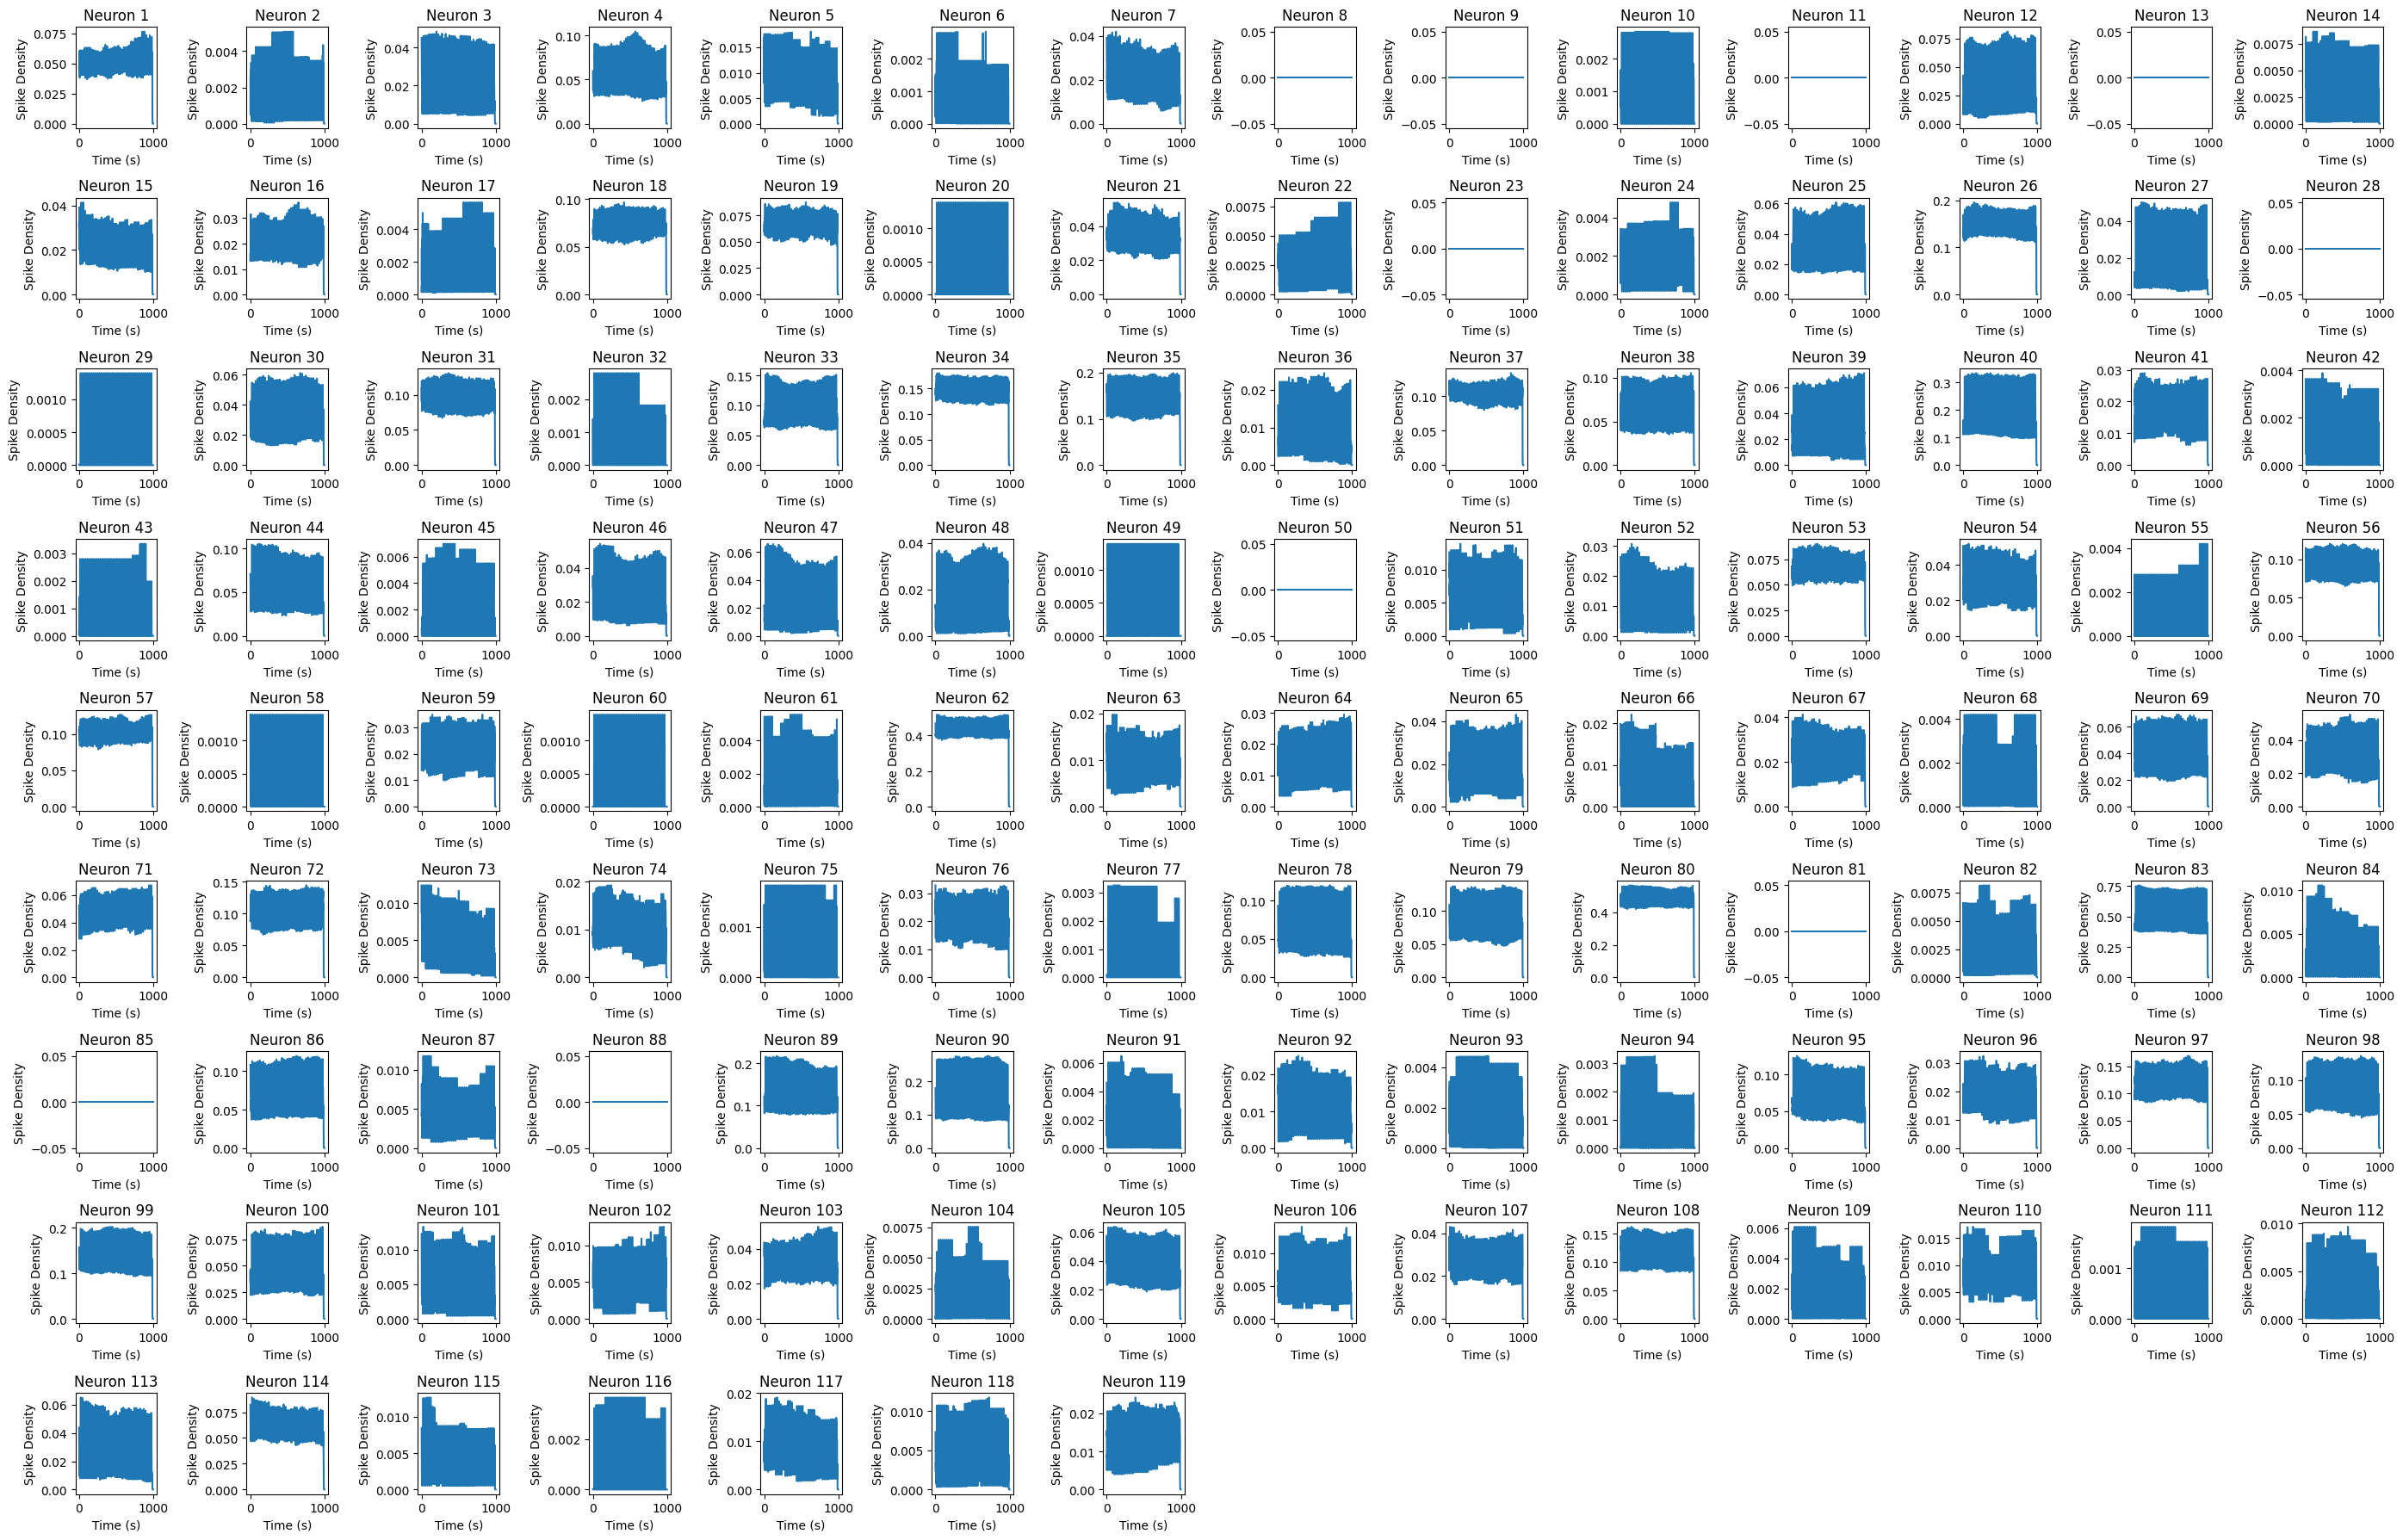

In [30]:
# Extract just the spike data from ys to create ys_array
ys_array = np.array([trial_data[0] for trial_data in ys])  # Shape: [n_trials, T_trial, N_neurons]

# Create the EPSP kernel
epsp_kernel = create_epsp_kernel(peak_time=1, decay_time=5, total_duration=25, sampling_rate=1)

# Function to apply EPSP kernel to all neurons' spike trains and compute SDF
def apply_kernel_to_all_neurons(ys_array, kernel):
    """
    Applies the EPSP kernel to spike trains of all neurons to compute the spike density function (SDF).

    Parameters:
    - ys_array: 3D array of spike counts, with dimensions [n_trials, T_trial, N_neurons]
    - kernel: 1D array representing the EPSP-shaped kernel

    Returns:
    - sdf_array: 3D array of spike density functions, same shape as ys_array
    """
    n_trials, T_trial, N_neurons = ys_array.shape
    sdf_array = np.zeros((n_trials, T_trial, N_neurons))
    
    for neuron in range(N_neurons):
        for trial in range(n_trials):
            sdf_array[trial, :, neuron] = scipy.signal.convolve(ys_array[trial, :, neuron], kernel, mode='same')
            
    return sdf_array

# Apply the kernel to all neurons
sdf_array = apply_kernel_to_all_neurons(ys_array, epsp_kernel)

# # Example: Plot the average SDF for the first 10 neurons 
# plt.figure(figsize=(10, 6))
# average_sdf_neurons = np.mean(sdf_array[:, :, :10], axis=0)
# for i in range(10):
#     plt.plot(average_sdf_neurons[:, i], label=f'Neuron {i+1}')

# plt.title('Average Spike Density Function (SDF) for Neurons 1-10')
# plt.ylabel('Spike Density')
# plt.xlabel('Time (s)')
# plt.legend()
# plt.show()
# Example: Plot the SDF for the first 10 neurons in a 2x5 grid
n_neurons = sdf_array.shape[2]  # Total number of neurons to plot
max_cols = 14  # Maximum number of columns

# Dynamically calculate the number of rows needed
n_cols = min(n_neurons, max_cols)
n_rows = int(np.ceil(n_neurons / n_cols))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

# Calculate the average SDF across trials for all neurons
average_sdf_neurons = np.mean(sdf_array[:, :, :n_neurons], axis=0)

# Plot each neuron's SDF in its respective subplot
for i in range(n_neurons):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].plot(average_sdf_neurons[:, i])
    axes[row, col].set_title(f'Neuron {i+1}')
    axes[row, col].set_xlabel('Time (s)')
    axes[row, col].set_ylabel('Spike Density')

# Remove unused subplots if any
for i in range(n_neurons, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Neurons with average SDF exceeding 0.01: [0, 2, 3, 4, 6, 11, 14, 15, 17, 18, 20, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 45, 46, 47, 50, 51, 52, 53, 55, 56, 58, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 82, 83, 85, 86, 88, 89, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 109, 112, 113, 114, 116, 117, 118]
Number of neurons above threshold: 79


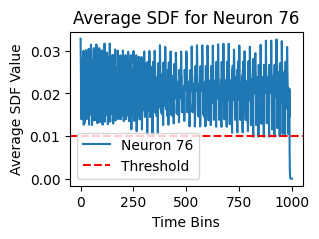

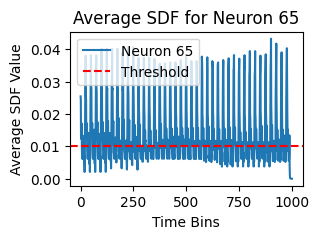

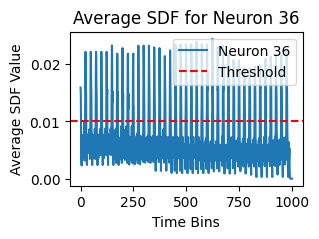

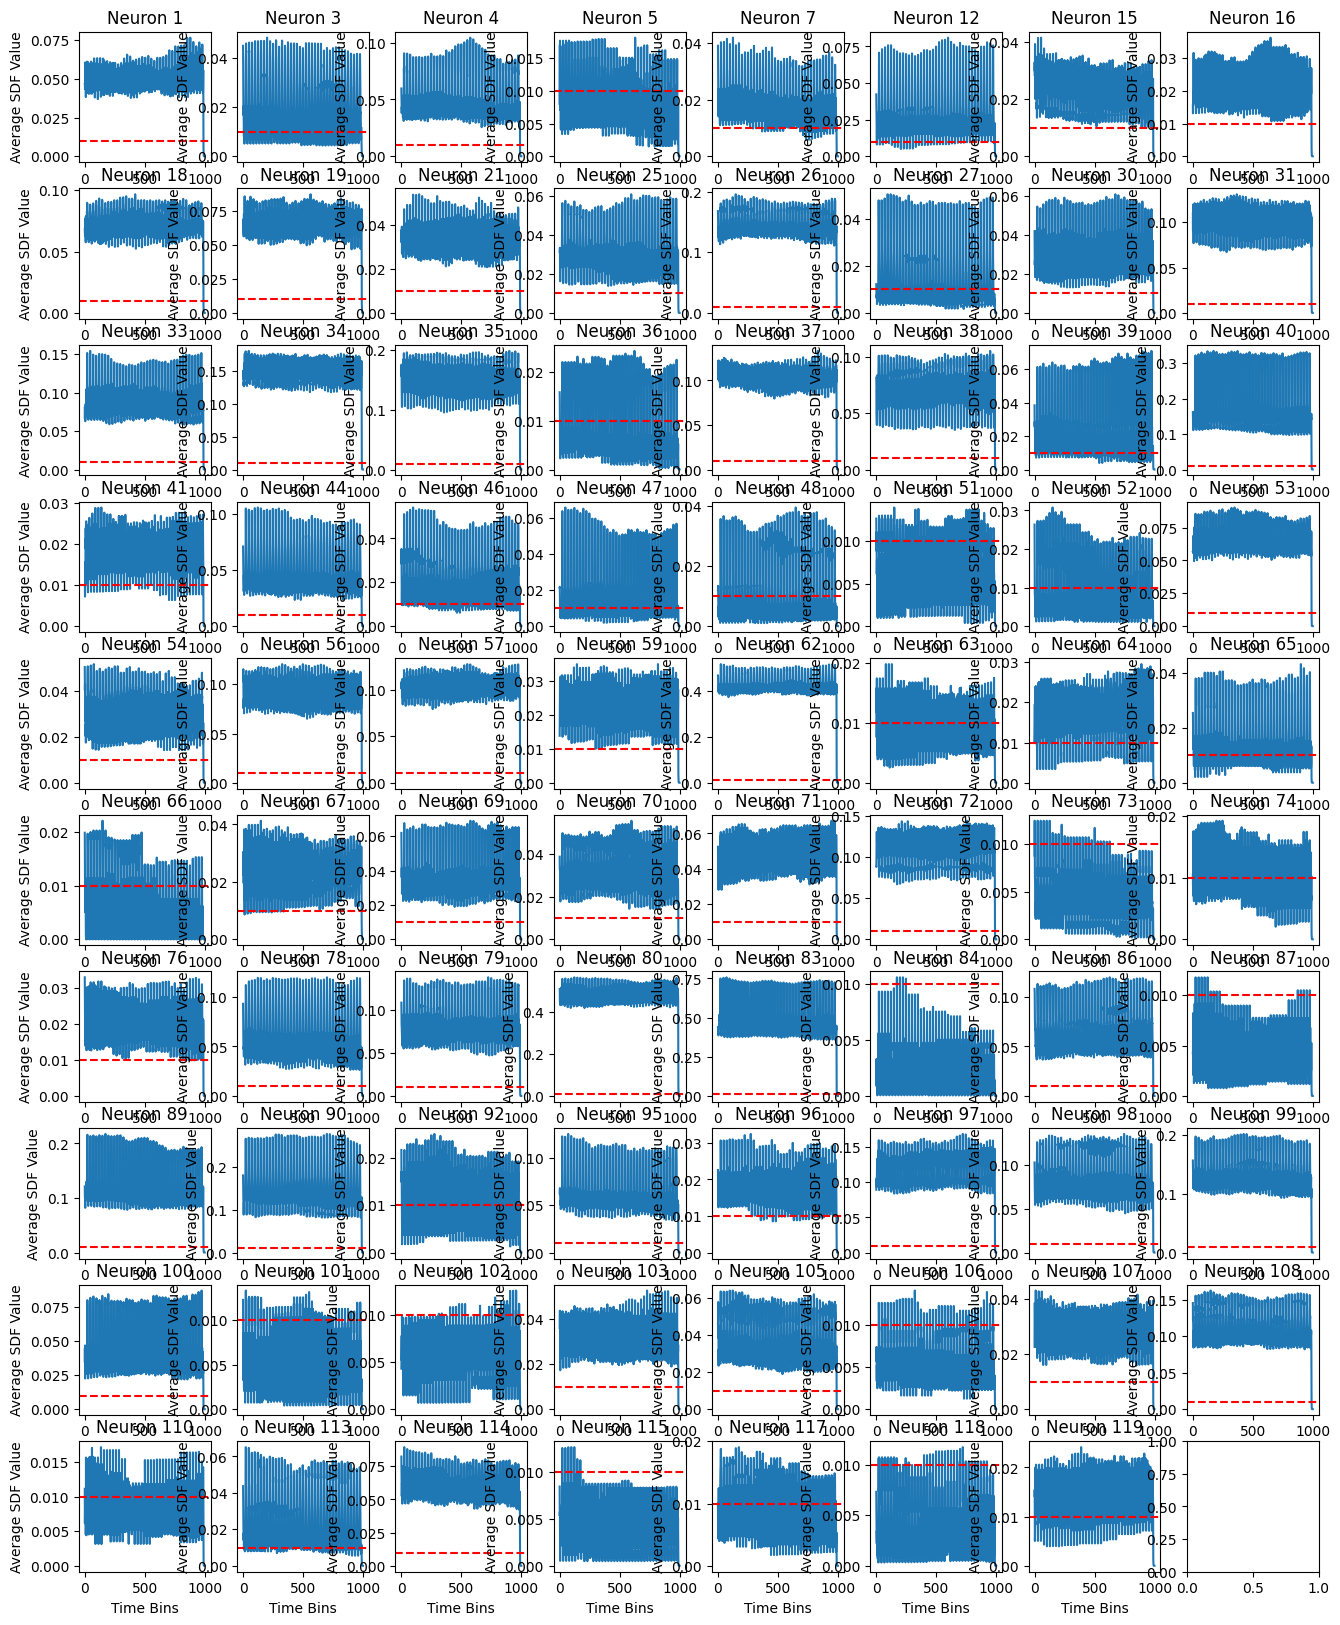

In [31]:
# Assuming ys is a numpy array with dimensions [n_trials, T_trial, N_neurons]
# And assuming you have defined your create_epsp_kernel() function elsewhere

# Create the EPSP kernel
epsp_kernel = create_epsp_kernel(peak_time=1, decay_time=5, total_duration=25, sampling_rate=1)

# Function to convert a spike train to an SDF using the EPSP kernel
def spike_train_to_sdf(spike_train, kernel):
    """
    Convert a spike train to a spike density function (SDF) using a specified kernel.
    """
    return scipy.signal.convolve(spike_train, kernel, mode='same')

# Calculate the average SDF for each neuron across all trials
average_sdfs = np.zeros((ys_array.shape[2], ys_array.shape[1]))  # Initialize the array [N_neurons, T_trial]

for neuron_id in range(ys_array.shape[2]):
    sdfs = []
    for trial in ys_array:
        sdf = spike_train_to_sdf(trial[:, neuron_id], epsp_kernel)
        sdfs.append(sdf)
    average_sdfs[neuron_id] = np.mean(sdfs, axis=0)

# check all the filtered sdfs and see if they go above a threshold of .01
threshold = 0.01
# Check if the average SDF for each neuron exceeds the threshold at any point
neurons_above_threshold = [i for i, avg_sdf in enumerate(average_sdfs) if np.any(avg_sdf > threshold)]

print(f"Neurons with average SDF exceeding {threshold}: {neurons_above_threshold}")
print(f"Number of neurons above threshold: {len(neurons_above_threshold)}")

# choose three random neurons to plot
random_neurons = np.random.choice(neurons_above_threshold, 3, replace=False)

# Plot the average SDFs that are above the threshold
for neuron_index in random_neurons:
    plt.figure(figsize=(3, 2))
    plt.plot(average_sdfs[neuron_index], label=f'Neuron {neuron_index + 1}')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.title(f'Average SDF for Neuron {neuron_index + 1}')
    plt.xlabel('Time Bins')
    plt.ylabel('Average SDF Value')
    plt.show()

n_neurons = len(neurons_above_threshold)  # Total number of neurons to plot
max_cols = 8  # Maximum number of columns

# Dynamically calculate the number of rows needed
n_cols = min(n_neurons, max_cols)
n_rows = int(np.ceil(n_neurons / n_cols))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, neuron_index in enumerate(neurons_above_threshold):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].plot(average_sdfs[neuron_index])
    axes[row, col].set_title(f'Neuron {neuron_index + 1}')
    axes[row, col].set_xlabel('Time Bins')
    axes[row, col].set_ylabel('Average SDF Value')
    axes[row, col].axhline(y=threshold, color='r', linestyle='--', label='Threshold')

Neurons with at least 500 time points above 0.008: [0, 2, 3, 6, 11, 14, 15, 17, 18, 20, 24, 25, 26, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 43, 45, 46, 52, 53, 55, 56, 58, 61, 62, 63, 64, 66, 68, 69, 70, 71, 73, 75, 77, 78, 79, 82, 85, 88, 89, 91, 94, 95, 96, 97, 98, 99, 102, 104, 106, 107, 109, 112, 113, 118]
Number of neurons above threshold: 64


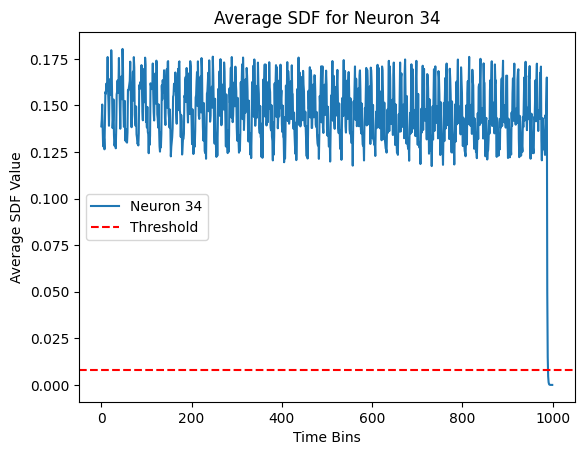

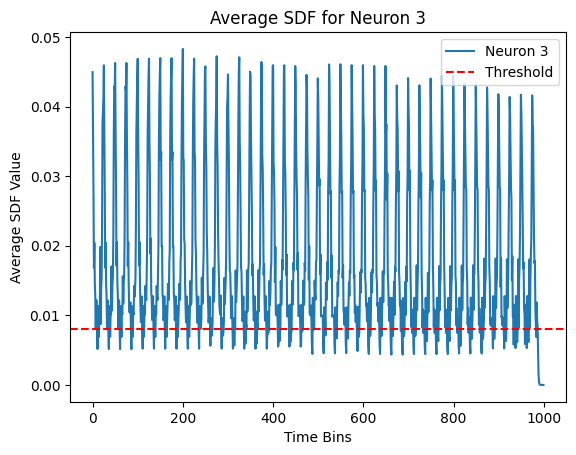

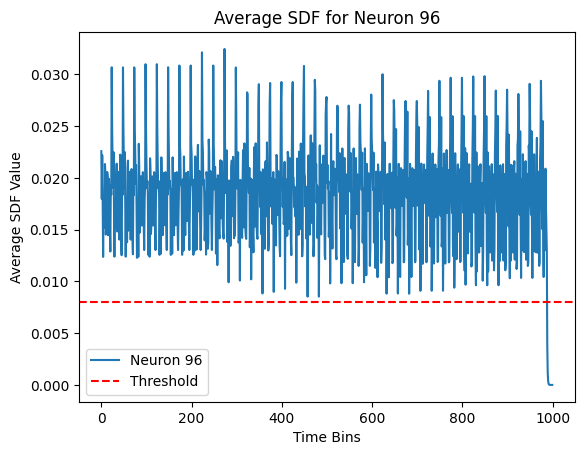

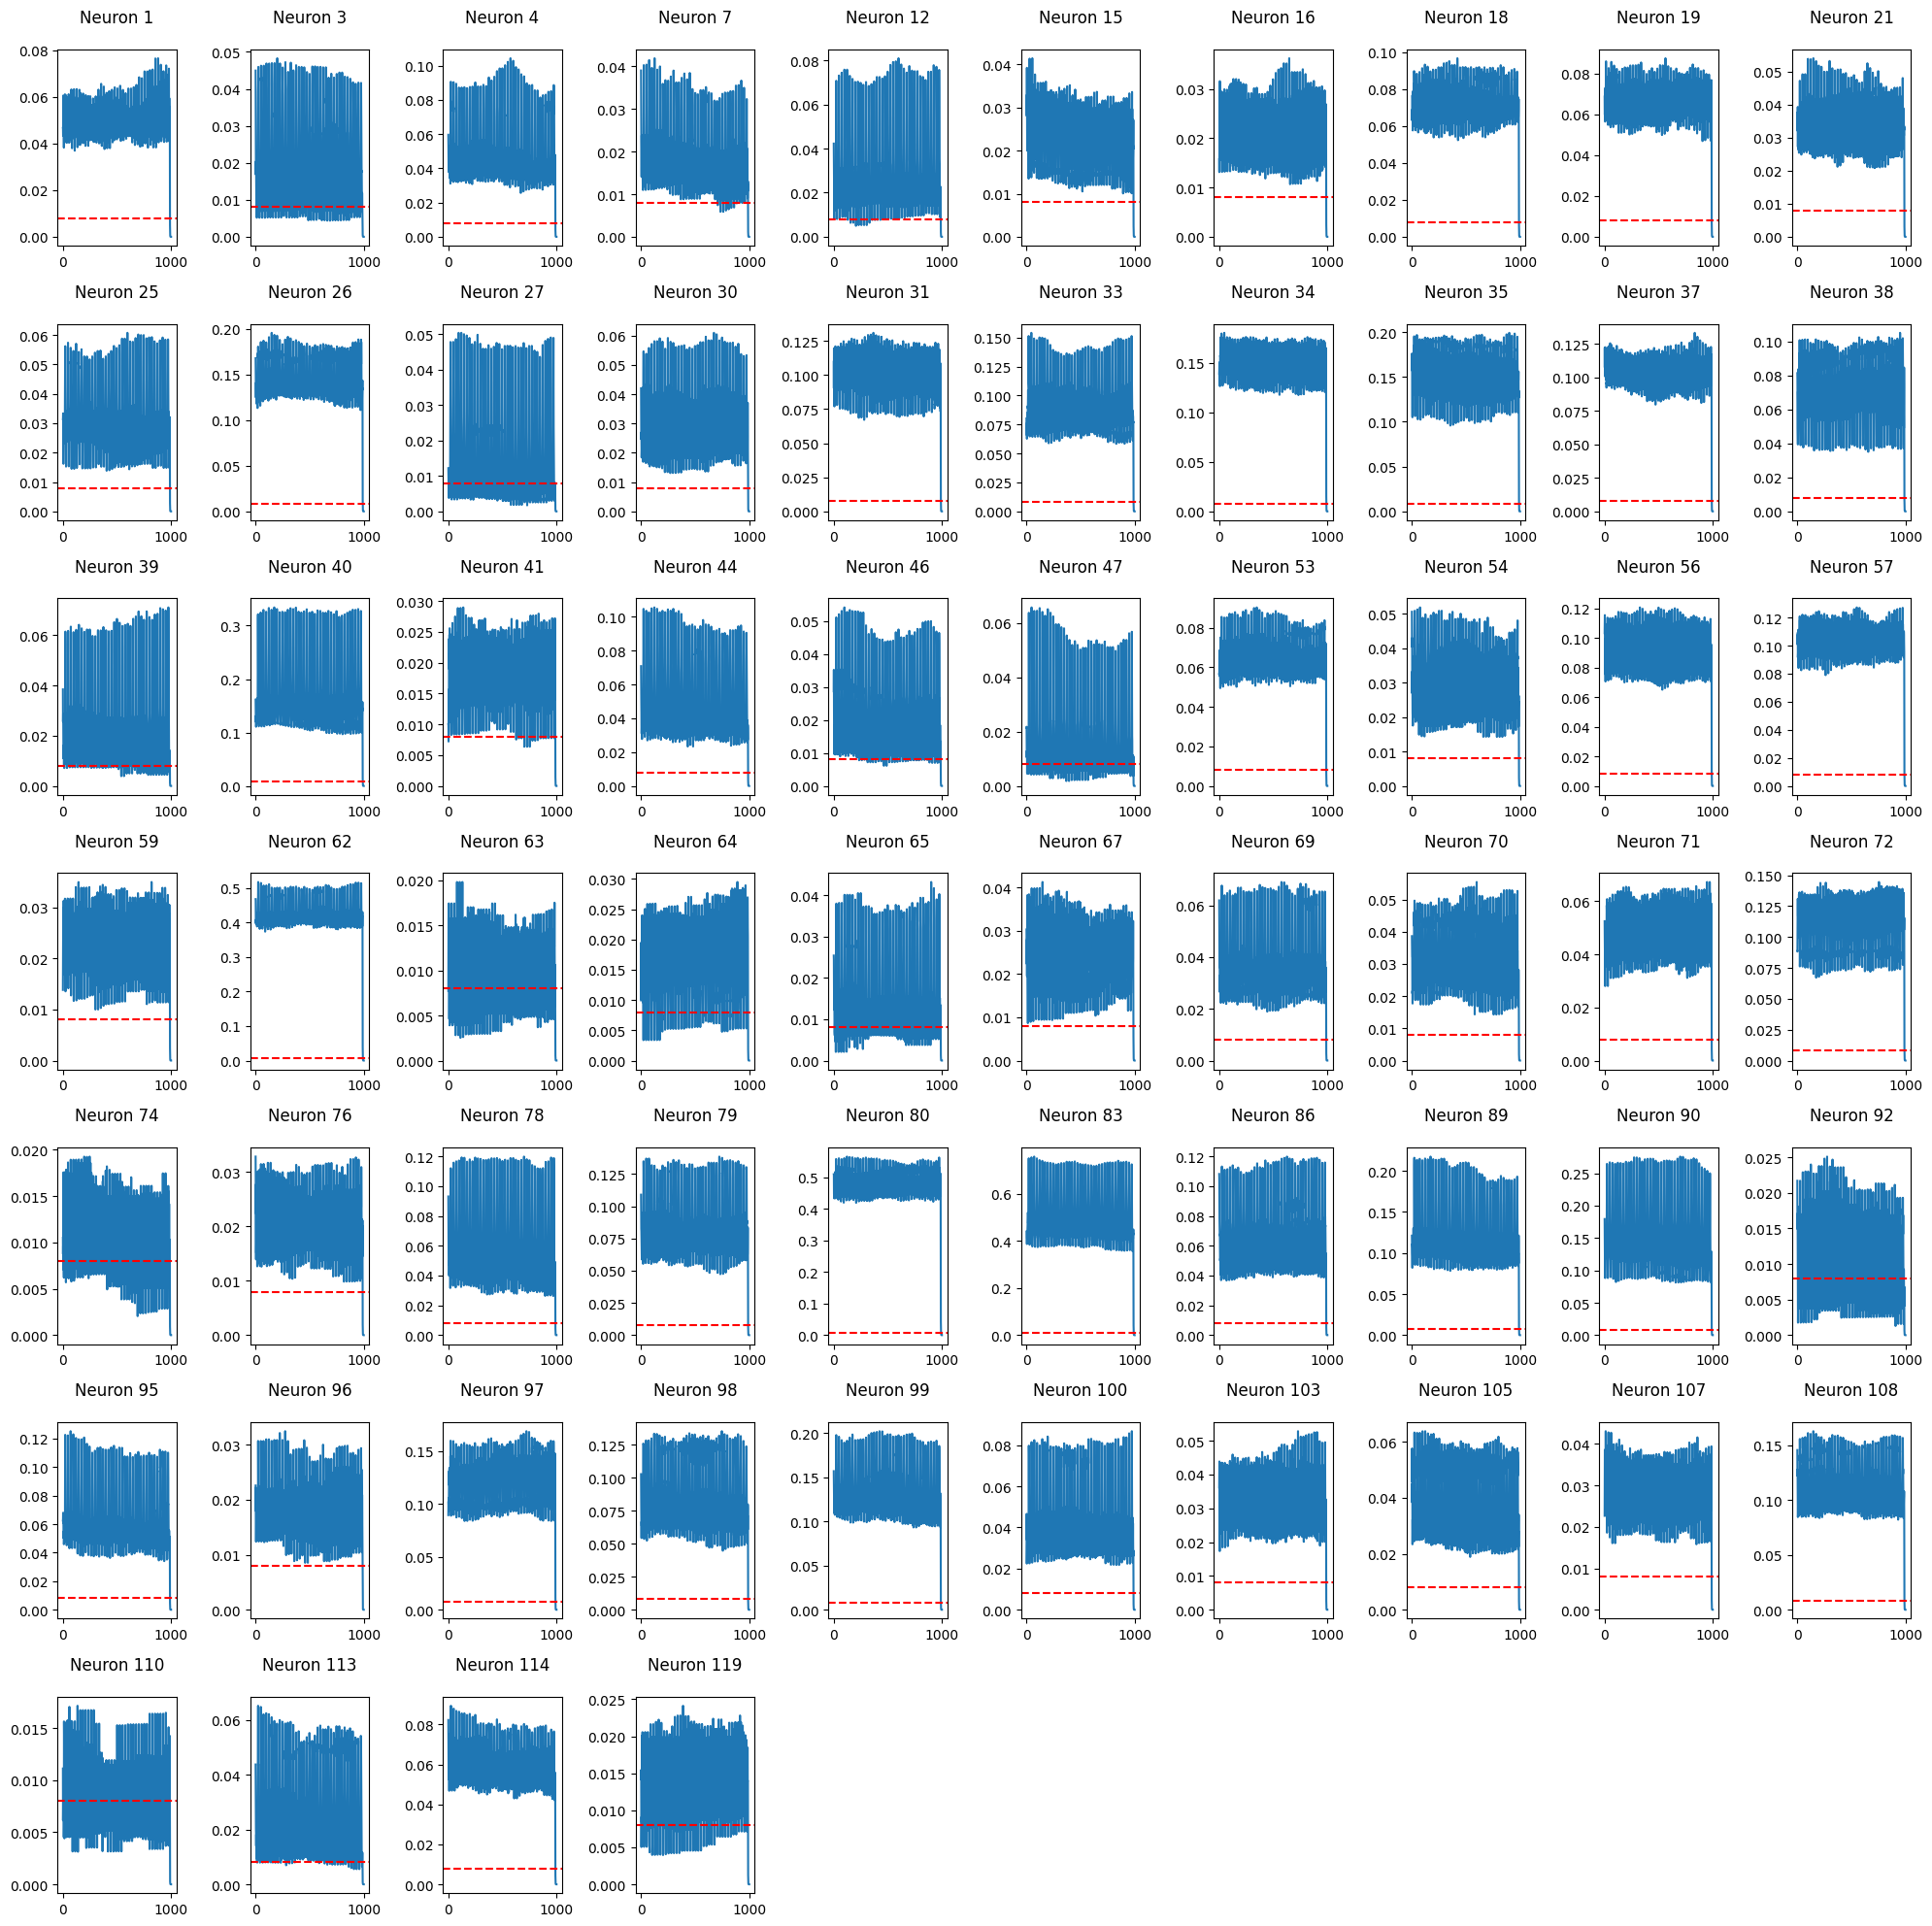

In [32]:
epsp_kernel = create_epsp_kernel(peak_time=1, decay_time=5, total_duration=25, sampling_rate=1)

# Threshold for SDF
threshold = 0.008
min_time_points = 500  # Minimum number of time points that need to exceed the threshold

# Check for neurons where the number of time points above the threshold is at least 500
neurons_above_threshold = [i for i, avg_sdf in enumerate(average_sdfs) if np.sum(avg_sdf > threshold) >= min_time_points]

print(f"Neurons with at least {min_time_points} time points above {threshold}: {neurons_above_threshold}")
print(f"Number of neurons above threshold: {len(neurons_above_threshold)}")

# Choose three random neurons to plot (if there are at least 3 neurons above the threshold)
if len(neurons_above_threshold) >= 3:
    random_neurons = np.random.choice(neurons_above_threshold, 3, replace=False)

    # Plot the average SDFs for the selected random neurons
    for neuron_index in random_neurons:
        plt.figure()
        plt.plot(average_sdfs[neuron_index], label=f'Neuron {neuron_index + 1}')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.legend()
        plt.title(f'Average SDF for Neuron {neuron_index + 1}')
        plt.xlabel('Time Bins')
        plt.ylabel('Average SDF Value')
        plt.show()
else:
    print(f"Not enough neurons with at least {min_time_points} time points above the threshold.")


n_neurons = len(neurons_above_threshold)  # Total number of neurons to plot
max_cols = 10  # Maximum number of columns

# Dynamically calculate the number of rows needed
n_cols = min(n_neurons, max_cols)
n_rows = int(np.ceil(n_neurons / n_cols))

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 3))  # Increase height

for i, neuron_index in enumerate(neurons_above_threshold):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].plot(average_sdfs[neuron_index])
    axes[row, col].set_title(f'Neuron {neuron_index + 1}', pad=20)  # Increase pad
    axes[row, col].axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Remove unused subplots if any
for j in range(n_neurons, n_rows * n_cols):
    fig.delaxes(axes.flat[j])

# Adjust layout to prevent overlap
plt.subplots_adjust(bottom=0.1)  # Increase bottom padding as needed
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top
plt.show()

significant_neurons = neurons_above_threshold

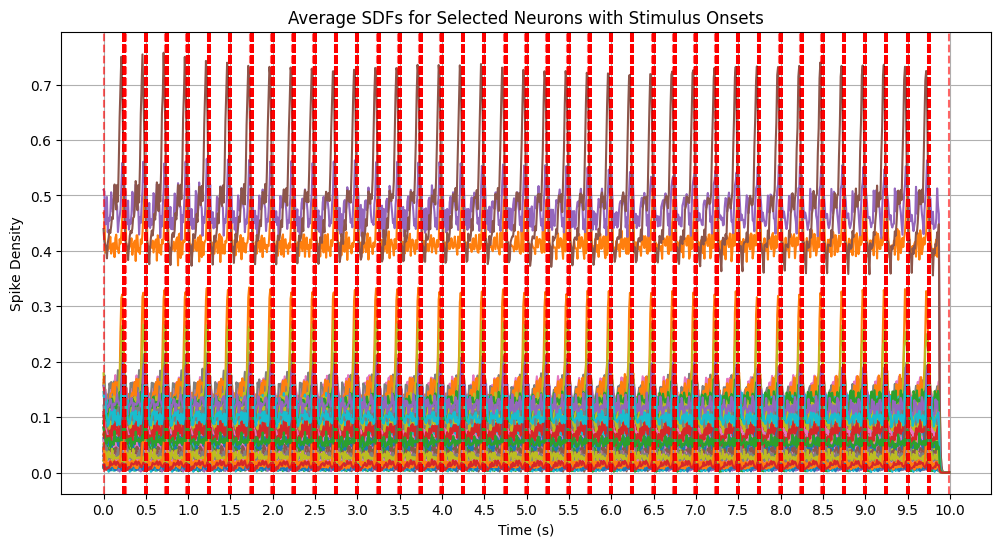

In [33]:


# Define the responsive neurons and initialize the SDF array
neuron_indices = significant_neurons
# neuron_indices = responsive_neurons
N_neurons = len(neuron_indices)
T_trial = int(10 / dt)  # 10 seconds divided into bins based on dt
average_sdfs = np.zeros((N_neurons, T_trial))  # N_neurons, full 10s (T_trial time points)

# Loop through each neuron and calculate the SDF
for neuron_index, neuron_id in enumerate(neuron_indices):
    sdfs = []
    for trial_data in ys:
        # Extract the spike data (first element of the tuple)
        y_trial = trial_data[0]
        
        # Compute the SDF for the current neuron in this trial
        sdf = spike_train_to_sdf(y_trial[:, neuron_id], epsp_kernel)
        
        # Append the full SDF for this trial to the list
        sdfs.append(sdf)  # Use the full length (T_trial)

    # Compute the average SDF across all trials for this neuron
    average_sdfs[neuron_index] = np.mean(sdfs, axis=0)

# Time range for the full 10 seconds
time_range = np.arange(0, 10, dt)

# Plotting the average SDFs of all selected neurons with the adjusted time range
plt.figure(figsize=(12, 6))
for i in range(N_neurons):
    plt.plot(time_range, average_sdfs[i], label=f'Neuron {neuron_indices[i] + 1}')

# Mark all stimulus onset times in red vertical lines
for trial_data in ys:
    _, stim_onset_indices = trial_data
    for stim_idx in stim_onset_indices:
        stim_time = time_range[stim_idx]
        plt.axvline(x=stim_time, color='red', linestyle='--', alpha=0.6)

plt.title('Average SDFs for Selected Neurons with Stimulus Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Spike Density')
plt.xticks(np.arange(0, 10.5, 0.5))  # Setting x-ticks at intervals of 0.5s
plt.grid(True)
plt.show()

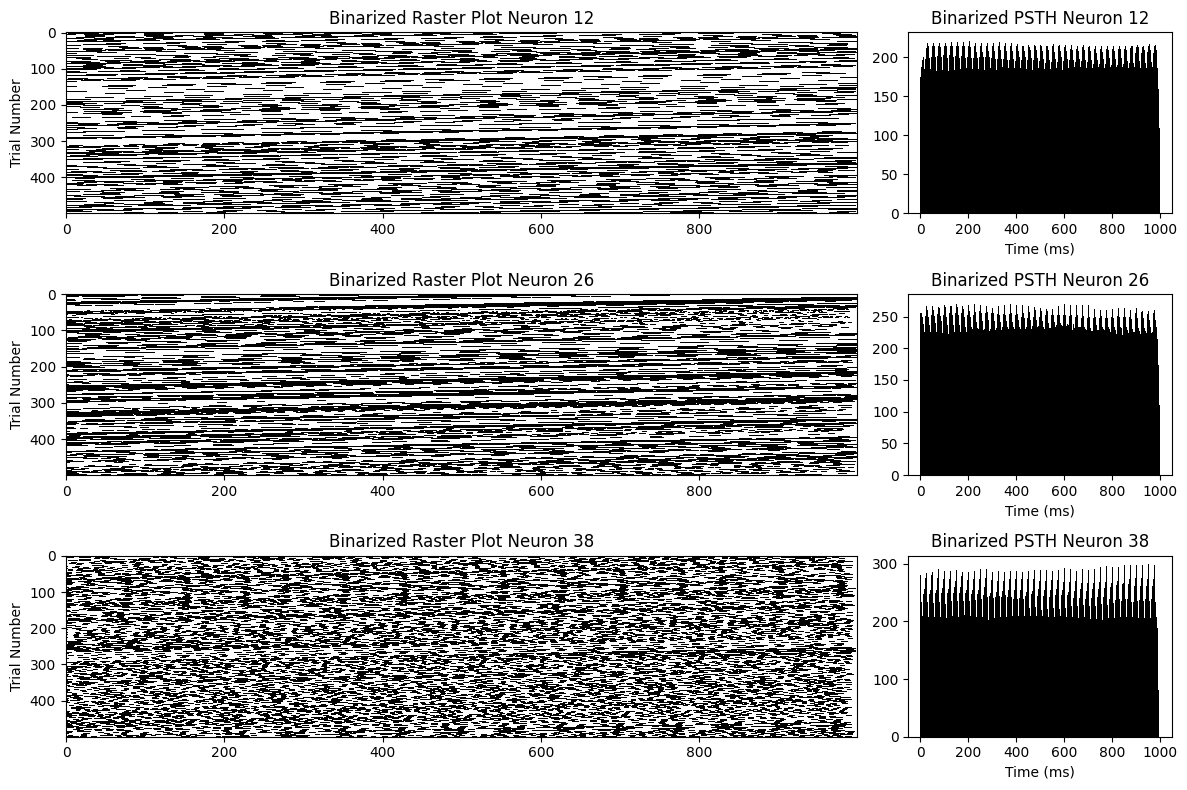

In [34]:
# Define the responsive neurons or specific neurons of interest
neuron_indices = [11, 25, 37]
N_neurons = len(neuron_indices)

# Initialize dictionaries to store binarized SDFs for each neuron
binarized_sdfs_per_neuron = {neuron_id: [] for neuron_id in neuron_indices}

# Binarizing SDFs based on the median for each trial
for trial_data in ys:
    y_trial = trial_data[0]  # Extract the spike data from the tuple
    
    for neuron_index, neuron_id in enumerate(neuron_indices):
        sdf = spike_train_to_sdf(y_trial[:, neuron_id], epsp_kernel)
        median_value = np.median(sdf)
        binarized_sdf = np.where(sdf > median_value, 1, 0)
        binarized_sdfs_per_neuron[neuron_id].append(binarized_sdf)

# Computing the PSTH for the binarized SDF data
psth_per_neuron = {neuron_id: np.sum(np.array(binarized_sdfs), axis=0) for neuron_id, binarized_sdfs in binarized_sdfs_per_neuron.items()}

# Identifying the active trials of the middle neuron (neuron with index 25 in the list)
middle_neuron_id = neuron_indices[1]
active_trials_middle_neuron = [np.any(y_trial[:, middle_neuron_id]) for y_trial, _ in ys]

# Recalculating binarized SDFs for each neuron using active trials of the middle neuron
binarized_sdfs_active_trials = []
for neuron_index, neuron_id in enumerate(neuron_indices):
    neuron_sdfs_active_trials = []
    for i, is_active in enumerate(active_trials_middle_neuron):
        if is_active:
            y_trial = ys[i][0]
            sdf = spike_train_to_sdf(y_trial[:, neuron_id], epsp_kernel)
            median_value = np.median(sdf)
            binarized_sdf = np.where(sdf > median_value, 1, 0)
            neuron_sdfs_active_trials.append(binarized_sdf)
    binarized_sdfs_active_trials.append(neuron_sdfs_active_trials)

# Plotting the raster plots and PSTHs for the binarized data using active trials of the middle neuron
fig, axs = plt.subplots(3, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 3, 3], 'width_ratios': [3, 1]})
for i, neuron_id in enumerate(neuron_indices):
    # Binarized raster plot for each neuron
    axs[i, 0].imshow(np.array(binarized_sdfs_active_trials[i]), cmap='Greys', aspect='auto', interpolation='none')
    axs[i, 0].set_title(f'Binarized Raster Plot Neuron {neuron_id + 1}')
    axs[i, 0].set_ylabel('Trial Number')

    # Binarized PSTH for each neuron
    psth_binarized_neuron = np.sum(np.array(binarized_sdfs_active_trials[i]), axis=0)
    axs[i, 1].bar(range(len(psth_binarized_neuron)), psth_binarized_neuron, width=1.0, color='black')
    axs[i, 1].set_title(f'Binarized PSTH Neuron {neuron_id + 1}')
    axs[i, 1].set_xlabel('Time (ms)')

plt.tight_layout()
plt.show()

In [35]:
import seaborn as sns
from itertools import product

def compute_tpm(trial_matrix):
    """
    Compute the Transition Probability Matrix (TPM) for a given trial.
    The TPM is a 2^n x 2^n matrix, where n is the number of neurons (rows in trial_matrix).
    """
    num_neurons = trial_matrix.shape[0]  # Number of neurons inferred from the trial matrix

    # Generate all possible states for n neurons and sort them in the specified order
    states = sorted(product(range(2), repeat=num_neurons), key=lambda x: (sum(x), x))

    # Initialize the TPM with zeros
    tpm = np.zeros((2**num_neurons, 2**num_neurons))

    # Count transitions between states
    for t in range(trial_matrix.shape[1] - 1):
        current_state = tuple(trial_matrix[:, t])
        next_state = tuple(trial_matrix[:, t + 1])

        if current_state in states and next_state in states:
            current_index = states.index(current_state)
            next_index = states.index(next_state)
            tpm[current_index, next_index] += 1

    # Normalize the TPM by row to get probabilities
    row_sums = tpm.sum(axis=1, keepdims=True)
    tpm_normalized = np.divide(tpm, row_sums, out=np.zeros_like(tpm), where=row_sums != 0)

    return tpm_normalized

/opt/miniconda3/envs/pyphi_c/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


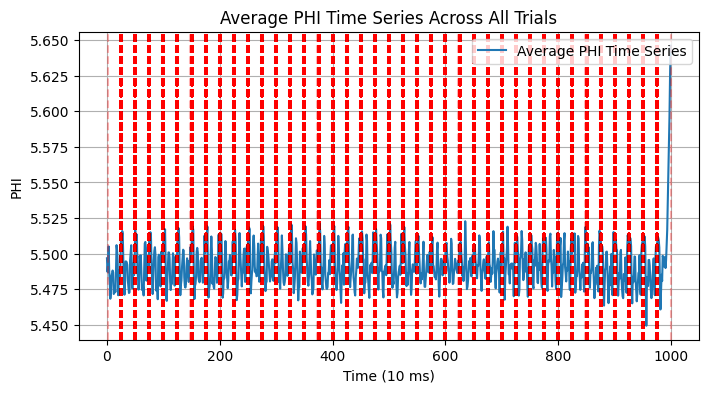

In [36]:
# Setting up the required parameters for pyPhi analysis
labels = ('A', 'B', 'C')
num_bits = len(labels)
possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

# Function to calculate phi values and states for a single TPM
def calculate_phi_for_tpm(tpm, possible_states, labels):
    converted_tpm = pyphi.convert.sbs2sbn(tpm)
    network = pyphi.Network(converted_tpm, node_labels=labels)
    node_indices = (0, 1, 2)

    phi_values = np.zeros(len(possible_states))
    phi_states = np.zeros((len(possible_states), 3), dtype=int)

    max_phi = -np.inf
    max_phi_state = None

    for i, state in enumerate(possible_states):
        try:
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state
        except pyphi.exceptions.StateUnreachableError:
            continue  # Skip this state if it's unreachable

    return phi_values, phi_states

# Concatenating binarized SDFs across all trials for each neuron to compute one TPM
binarized_sdfs_concat = []

for neuron_id in range(num_bits):
    # Concatenate the binarized SDFs for this neuron across all trials
    concatenated_sdf = np.concatenate([binarized_sdfs_active_trials[neuron_id][trial] for trial in range(len(binarized_sdfs_active_trials[neuron_id]))], axis=0)
    binarized_sdfs_concat.append(concatenated_sdf)

# Convert the list to a numpy array (shape: [num_neurons, total_time_points])
binarized_sdfs_concat = np.array(binarized_sdfs_concat)

# Compute the TPM over the entire stimulus window (across all trials)
tpm_over_all_trials = compute_tpm(binarized_sdfs_concat)

# Calculate phi values and states for the single TPM over all trials
phi_values, phi_states = calculate_phi_for_tpm(tpm_over_all_trials, possible_states, labels)

# Create a dictionary mapping each state to its corresponding PHI value
state_to_phi = {tuple(state): phi for state, phi in zip(phi_states, phi_values)}

# List to store PHI time series for each trial
phi_time_series_per_trial = []

# Loop over each trial
for trial in range(len(binarized_sdfs_active_trials[0])):
    # Extract the binarized SDFs for the trial (shape: [num_neurons, time_points])
    trial_time_series = np.array([binarized_sdfs_active_trials[neuron][trial] for neuron in range(num_bits)]).T
    
    # Map the observed states to their corresponding PHI values for this trial
    trial_phi_time_series = np.array([state_to_phi.get(tuple(state), 0) for state in trial_time_series])
    
    # Append the trial's PHI time series to the list
    phi_time_series_per_trial.append(trial_phi_time_series)

# Convert to numpy array (shape: [num_trials, time_points])
phi_time_series_per_trial = np.array(phi_time_series_per_trial)

# Compute the average PHI time series across all trials
average_phi_time_series = np.mean(phi_time_series_per_trial, axis=0)
# median_phi_time_series = np.median(phi_time_series_per_trial, axis=0)

# Plot the average PHI time series across all trials
plt.figure(figsize=(8, 4))
plt.plot(average_phi_time_series, label='Average PHI Time Series')

# Now add vertical red dotted lines for each stimulus onset
for i, (y_trial, stim_onset_indices) in enumerate(ys):
    for stim_idx in stim_onset_indices:
        plt.axvline(x=stim_idx, color='red', linestyle='--', alpha=0.3)


plt.title('Average PHI Time Series Across All Trials')
plt.xlabel('Time (10 ms)')
plt.ylabel('PHI')
plt.legend()
plt.grid(True)
plt.show()

Shape of extracted PHI windows: (19500, 25)


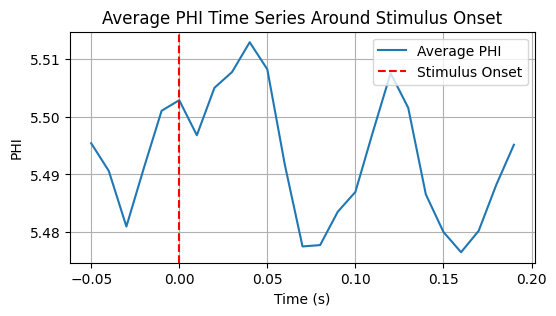

In [37]:
# Define the time window of interest relative to stimulus onset
pre_stimulus_time = 0.05  # 50ms before stimulus onset
post_stimulus_time = 0.2  # 200ms after stimulus onset
window_duration = pre_stimulus_time + post_stimulus_time
window_size = int(window_duration / dt)  # Total number of time bins in the window

# List to store extracted PHI time series windows for all trials
phi_windows_per_trial = []

# Loop through each trial and extract the PHI time series around each stimulus onset
for trial_idx, trial_phi_time_series in enumerate(phi_time_series_per_trial):
    for stim_on_time in stim_on_times:
        # Convert stimulus onset time to an index in the PHI time series
        stim_on_idx = int((stim_on_time - stim_on_times[0]) / dt)
        
        # Calculate the start and end indices for the window around the stimulus onset
        start_idx = stim_on_idx - int(pre_stimulus_time / dt)
        end_idx = stim_on_idx + int(post_stimulus_time / dt)
        
        # Ensure indices are within bounds for this trial
        if start_idx >= 0 and end_idx <= len(trial_phi_time_series):
            # Extract the PHI values in the specified window for this trial
            phi_window = trial_phi_time_series[start_idx:end_idx]
            phi_windows_per_trial.append(phi_window)

# Convert list to numpy array for easier averaging
phi_windows_array = np.array(phi_windows_per_trial)
print(f"Shape of extracted PHI windows: {phi_windows_array.shape}")

# Compute the average and median PHI values across all trials for each time point within the window
average_phi_window = np.mean(phi_windows_array, axis=0)

# Time range for the window (relative to stimulus onset)
time_window = np.arange(-pre_stimulus_time, post_stimulus_time, dt)

# Plot the average and median PHI time series within the window
plt.figure(figsize=(6, 3))
plt.plot(time_window, average_phi_window, label='Average PHI')
plt.title('Average PHI Time Series Around Stimulus Onset')
plt.xlabel('Time (s)')
plt.ylabel('PHI')
plt.axvline(x=0, color='red', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)
plt.show()

Processing group 1 of 5: Neurons [0, 62, 97]


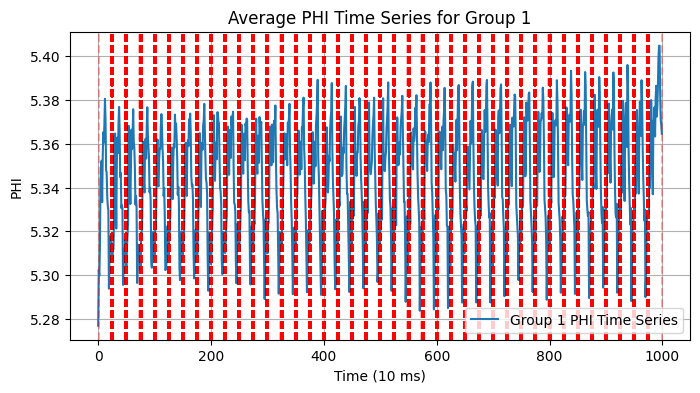

Processing group 2 of 5: Neurons [77, 20, 64]


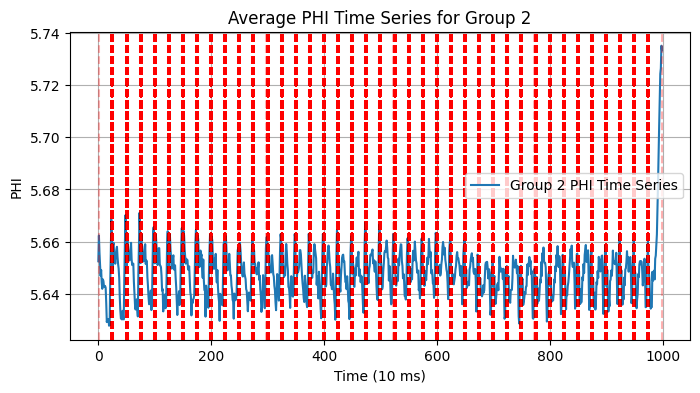

Processing group 3 of 5: Neurons [58, 78, 24]


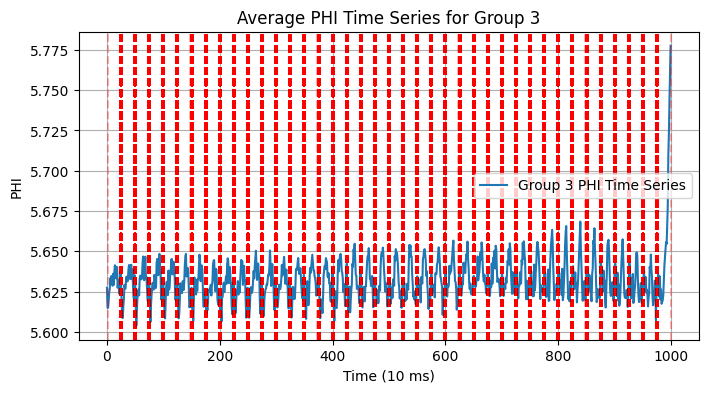

Processing group 4 of 5: Neurons [3, 15, 61]


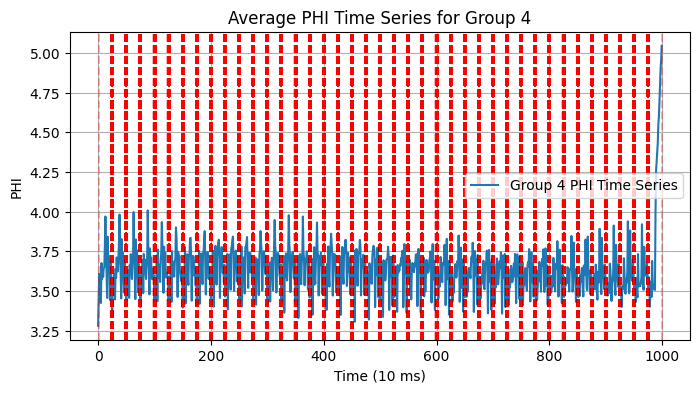

Processing group 5 of 5: Neurons [113, 95, 46]


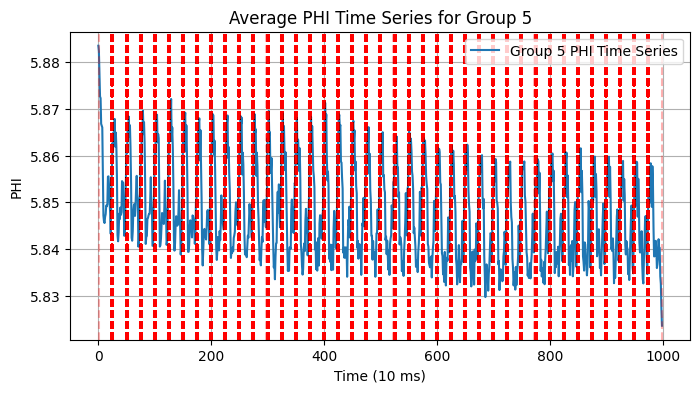

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# Assuming neuron_indices includes all available neurons
N_total_neurons = len(neurons_above_threshold)  # Use your full set of neurons here

# Shuffle the neuron indices to randomize their order
random_neuron_indices = neurons_above_threshold.copy()
random.shuffle(random_neuron_indices)

# Group neurons into groups of 3
neuron_groups = [random_neuron_indices[i:i+3] for i in range(0, len(random_neuron_indices), 3)]

# If the last group has fewer than three neurons, discard it
if len(neuron_groups[-1]) != 3:
    neuron_groups.pop()

# for testing just use the first 5 groups
neuron_groups = neuron_groups[:5]
# Initialize a list to store PHI time series results for each group
all_group_phi_results = []

# Process each group of 3 neurons
for group_idx, group in enumerate(neuron_groups):
    print(f'Processing group {group_idx + 1} of {len(neuron_groups)}: Neurons {group}')

    # Initialize dictionaries to store binarized SDFs for each neuron in the group
    binarized_sdfs_per_neuron = {neuron_id: [] for neuron_id in group}

    # Binarize the SDFs for each neuron based on the median for each trial
    for trial_data in ys:
        y_trial = trial_data[0]
        for neuron_id in group:
            sdf = spike_train_to_sdf(y_trial[:, neuron_id], epsp_kernel)
            median_value = np.median(sdf)
            binarized_sdf = np.where(sdf > median_value, 1, 0)
            binarized_sdfs_per_neuron[neuron_id].append(binarized_sdf)

    # Recalculate binarized SDFs for each neuron using active trials
    binarized_sdfs_active_trials = []
    for neuron_id in group:
        neuron_sdfs_active_trials = []
        for i, is_active in enumerate(active_trials_middle_neuron):
            if is_active:
                y_trial = ys[i][0]
                sdf = spike_train_to_sdf(y_trial[:, neuron_id], epsp_kernel)
                median_value = np.median(sdf)
                binarized_sdf = np.where(sdf > median_value, 1, 0)
                neuron_sdfs_active_trials.append(binarized_sdf)
        binarized_sdfs_active_trials.append(neuron_sdfs_active_trials)

    # Concatenate binarized SDFs across all trials for each neuron to compute the TPM
    binarized_sdfs_concat = []
    for neuron_id in range(len(group)):
        concatenated_sdf = np.concatenate([binarized_sdfs_active_trials[neuron_id][trial] for trial in range(len(binarized_sdfs_active_trials[neuron_id]))], axis=0)
        binarized_sdfs_concat.append(concatenated_sdf)

    binarized_sdfs_concat = np.array(binarized_sdfs_concat)

    # Compute the TPM for the current group
    tpm_over_all_trials = compute_tpm(binarized_sdfs_concat)

    # Calculate PHI values for the group
    phi_values, phi_states = calculate_phi_for_tpm(tpm_over_all_trials, possible_states, labels)

    # Map each state to its corresponding PHI value
    state_to_phi = {tuple(state): phi for state, phi in zip(phi_states, phi_values)}

    # Calculate the PHI time series for each trial
    phi_time_series_per_trial = []
    for trial in range(len(binarized_sdfs_active_trials[0])):
        trial_time_series = np.array([binarized_sdfs_active_trials[neuron][trial] for neuron in range(len(group))]).T
        trial_phi_time_series = np.array([state_to_phi.get(tuple(state), 0) for state in trial_time_series])
        phi_time_series_per_trial.append(trial_phi_time_series)

    # Convert to numpy array
    phi_time_series_per_trial = np.array(phi_time_series_per_trial)

    # Compute the average PHI time series across all trials for the current group
    average_phi_time_series = np.mean(phi_time_series_per_trial, axis=0)

    # Store the result for this group
    all_group_phi_results.append({
        'group': group,
        'average_phi_time_series': average_phi_time_series
    })

    # Plot the PHI time series for this group
    plt.figure(figsize=(8, 4))
    plt.plot(average_phi_time_series, label=f'Group {group_idx + 1} PHI Time Series')
    
    # Now add vertical red dotted lines for each stimulus onset
    for i, (y_trial, stim_onset_indices) in enumerate(ys):
        for stim_idx in stim_onset_indices:
            plt.axvline(x=stim_idx, color='red', linestyle='--', alpha=0.3)

    plt.title(f'Average PHI Time Series for Group {group_idx + 1}')
    plt.xlabel('Time (10 ms)')
    plt.ylabel('PHI')
    plt.legend()
    plt.grid(True)
    plt.show()



(39, 25)


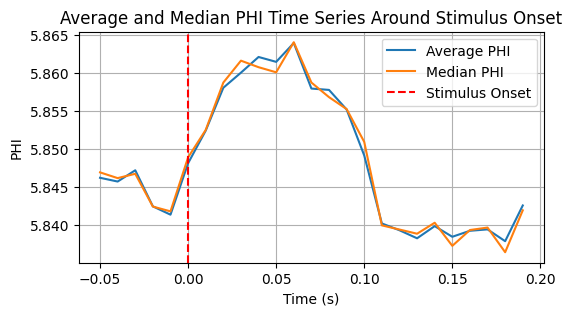

In [39]:
# Define the time window of interest relative to stimulus onset
pre_stimulus_time = 0.05  # 50ms before stimulus onset
post_stimulus_time = 0.2  # 200ms after stimulus onset
window_duration = pre_stimulus_time + post_stimulus_time
window_size = int(window_duration / dt)  # Total number of time bins in the window

# List to store extracted PHI time series windows for all trials
phi_windows_per_trial = []

# Loop through each trial and extract the relevant PHI time series data
for i, stim_on_time in enumerate(stim_on_times):
    # Convert stimulus onset time to an index in the PHI time series
    stim_on_idx = int((stim_on_time - stim_on_times[0]) / dt)
    
    # Calculate the start and end indices for the window around the stimulus onset
    start_idx = stim_on_idx - int(pre_stimulus_time / dt)
    end_idx = stim_on_idx + int(post_stimulus_time / dt)
    
    # Ensure indices are within bounds
    if start_idx >= 0 and end_idx <= len(average_phi_time_series):
        # Extract the PHI values in the specified window
        phi_window = average_phi_time_series[start_idx:end_idx]
        phi_windows_per_trial.append(phi_window)

# Convert list to numpy array for easier averaging
phi_windows_array = np.array(phi_windows_per_trial)
print(phi_windows_array.shape)

# Compute the average PHI values across all trials for each time point within the window
average_phi_window = np.mean(phi_windows_array, axis=0)
median_phi_window = np.median(phi_windows_array, axis=0)

# Time range for the window (relative to stimulus onset)
time_window = np.arange(-pre_stimulus_time, post_stimulus_time, dt)

# Plot the average PHI time series within the window
plt.figure(figsize=(6, 3))
plt.plot(time_window, average_phi_window, label='Average PHI')
plt.plot(time_window, median_phi_window, label='Median PHI')
plt.title('Average and Median PHI Time Series Around Stimulus Onset')
plt.xlabel('Time (s)')
plt.ylabel('PHI')
plt.axvline(x=0, color='red', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)
plt.show()
